In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pymc as pm
from pymc.ode import DifferentialEquation

from itertools import product
import os.path as osp
from scipy.optimize import leastsq
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import math
import time
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
from IPython.display import display as print

from scipy.integrate import odeint


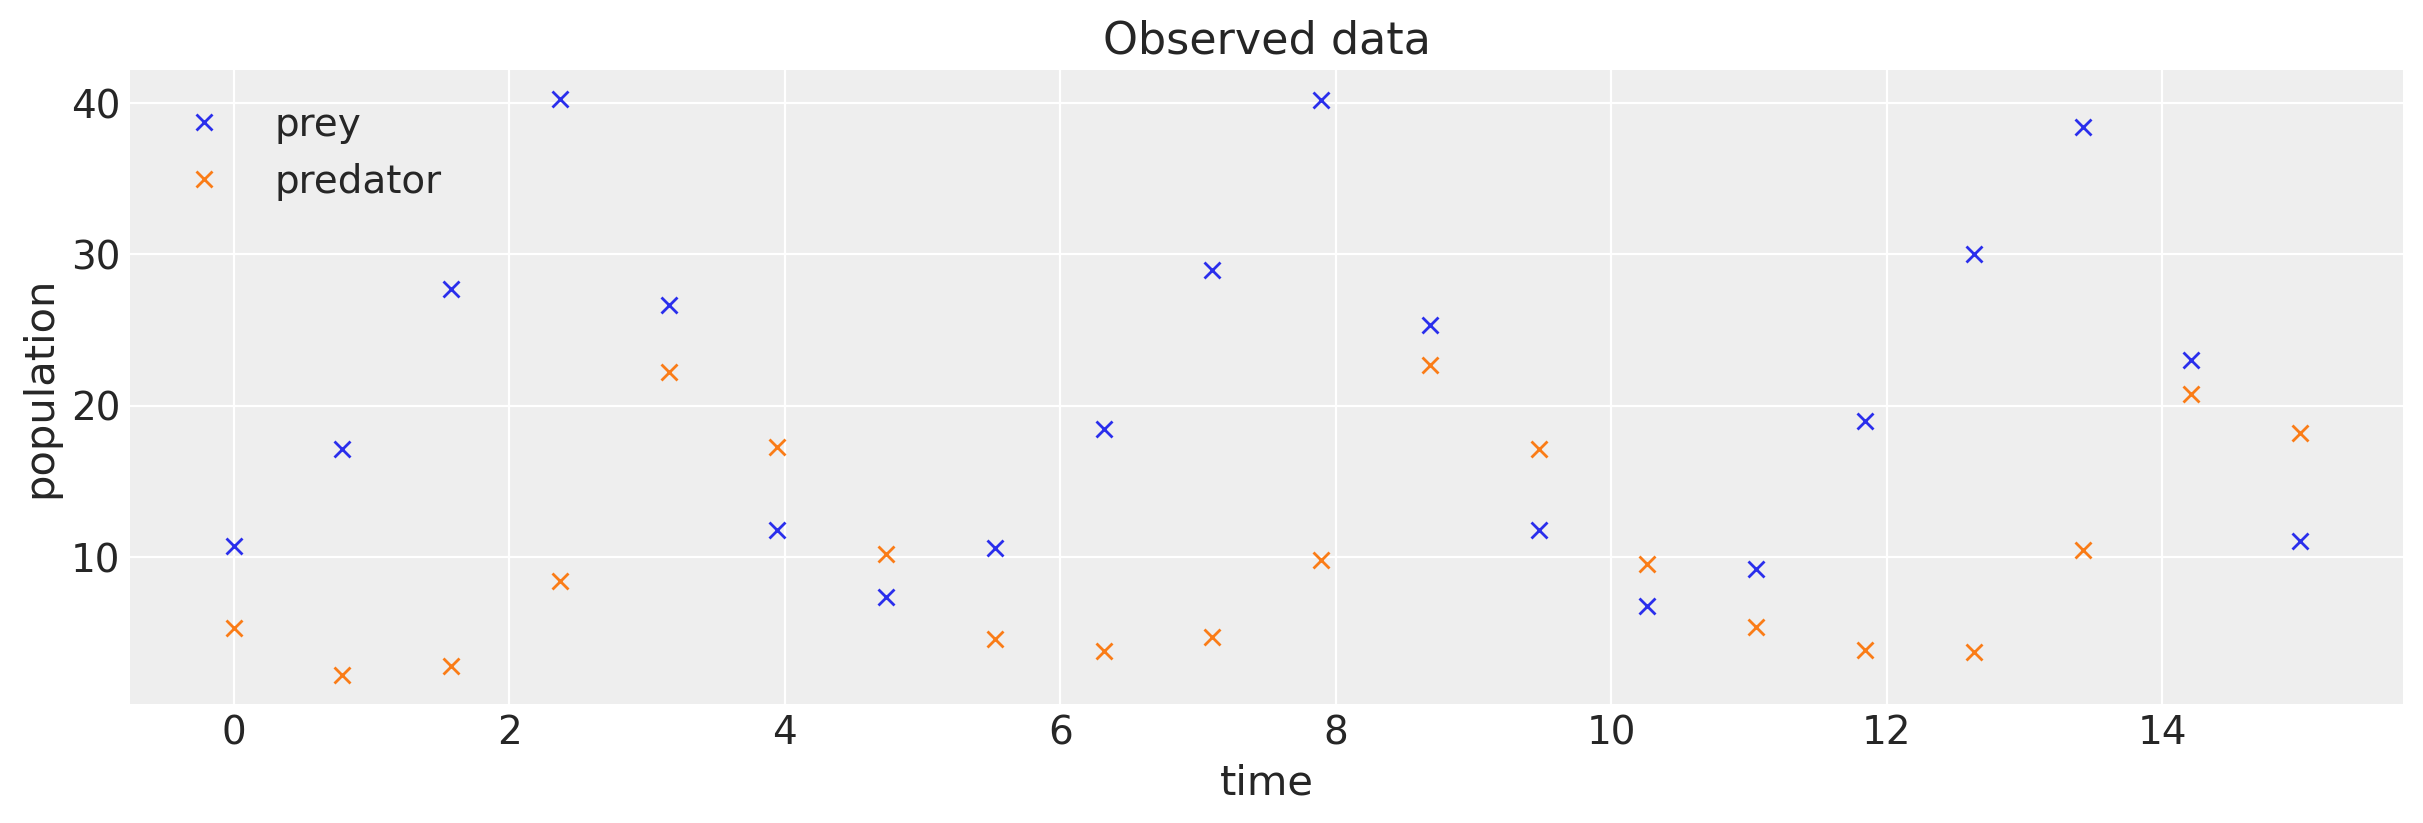

In [2]:
# Definition of parameters
a = 1.0
b = 0.1
c = 1.5
d = 0.75

# initial population of rabbits and foxes
y0 = [10.0, 5.0]
# size of data
size = 20
# time lapse
time = 15
t = np.linspace(0, time, size)

# Lotka - Volterra equation
def dX_dt(y, t, a, b, c, d):
    """Return the growth rate of fox and rabbit populations."""

    return np.array([a * y[0] - b * y[0] * y[1], -c * y[1] + d * b * y[0] * y[1]])


# simulator function
def competition_model(rng, y0, a, b, size=None):
    
    return odeint(dX_dt, y0=y0, t=t, rtol=0.01, args=(a, b, c, d))

# function for generating noisy data to be used as observed data.
def add_noise(y0, a, b):
    noise = np.random.normal(size=(size, 2))
    simulated = competition_model(None, y0, a, b) + noise
    return simulated

# plotting observed data.
observed = add_noise(y0, a, b)
_, ax = plt.subplots(figsize=(12, 4))
ax.plot(t, observed[:, 0],"x", label="prey")
ax.plot(t, observed[:, 1], "x", label="predator")
ax.set_xlabel("time")
ax.set_ylabel("population")
ax.set_title("Observed data")
ax.legend();

In [3]:
print(observed.shape)
print(t.shape)
observed[:, 0]


(20, 2)

(20,)

array([10.7135359 , 17.10956548, 27.7205354 , 40.26424432, 26.62507837,
       11.76684278,  7.34818585, 10.60781409, 18.42475288, 28.9882268 ,
       40.21343138, 25.29558318, 11.79060946,  6.75      ,  9.19378491,
       18.9827259 , 30.03143367, 38.41652285, 23.01333528, 11.05709966])

In [4]:
with pm.Model() as model_lv:
    a = pm.HalfNormal("a", 1.0)
    b = pm.HalfNormal("b", 1.0)
    
    # y0_1 = pm.HalfNormal("y0_1", 10)
    # y0_2 = pm.HalfNormal("y0_2", 10)

    # y0_1 = pm.DiracDelta("y0_1", 10)
    # y0_2 = pm.DiracDelta("y0_2", 5)
    y0_1,y0_2 = 10, 5

    sim = pm.Simulator("sim", competition_model, params=((y0_1,y0_2), a, b), epsilon=0.001, observed=observed,distance="laplace")

    idata_lv = pm.sample_smc(draws=2000, cores=4)

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


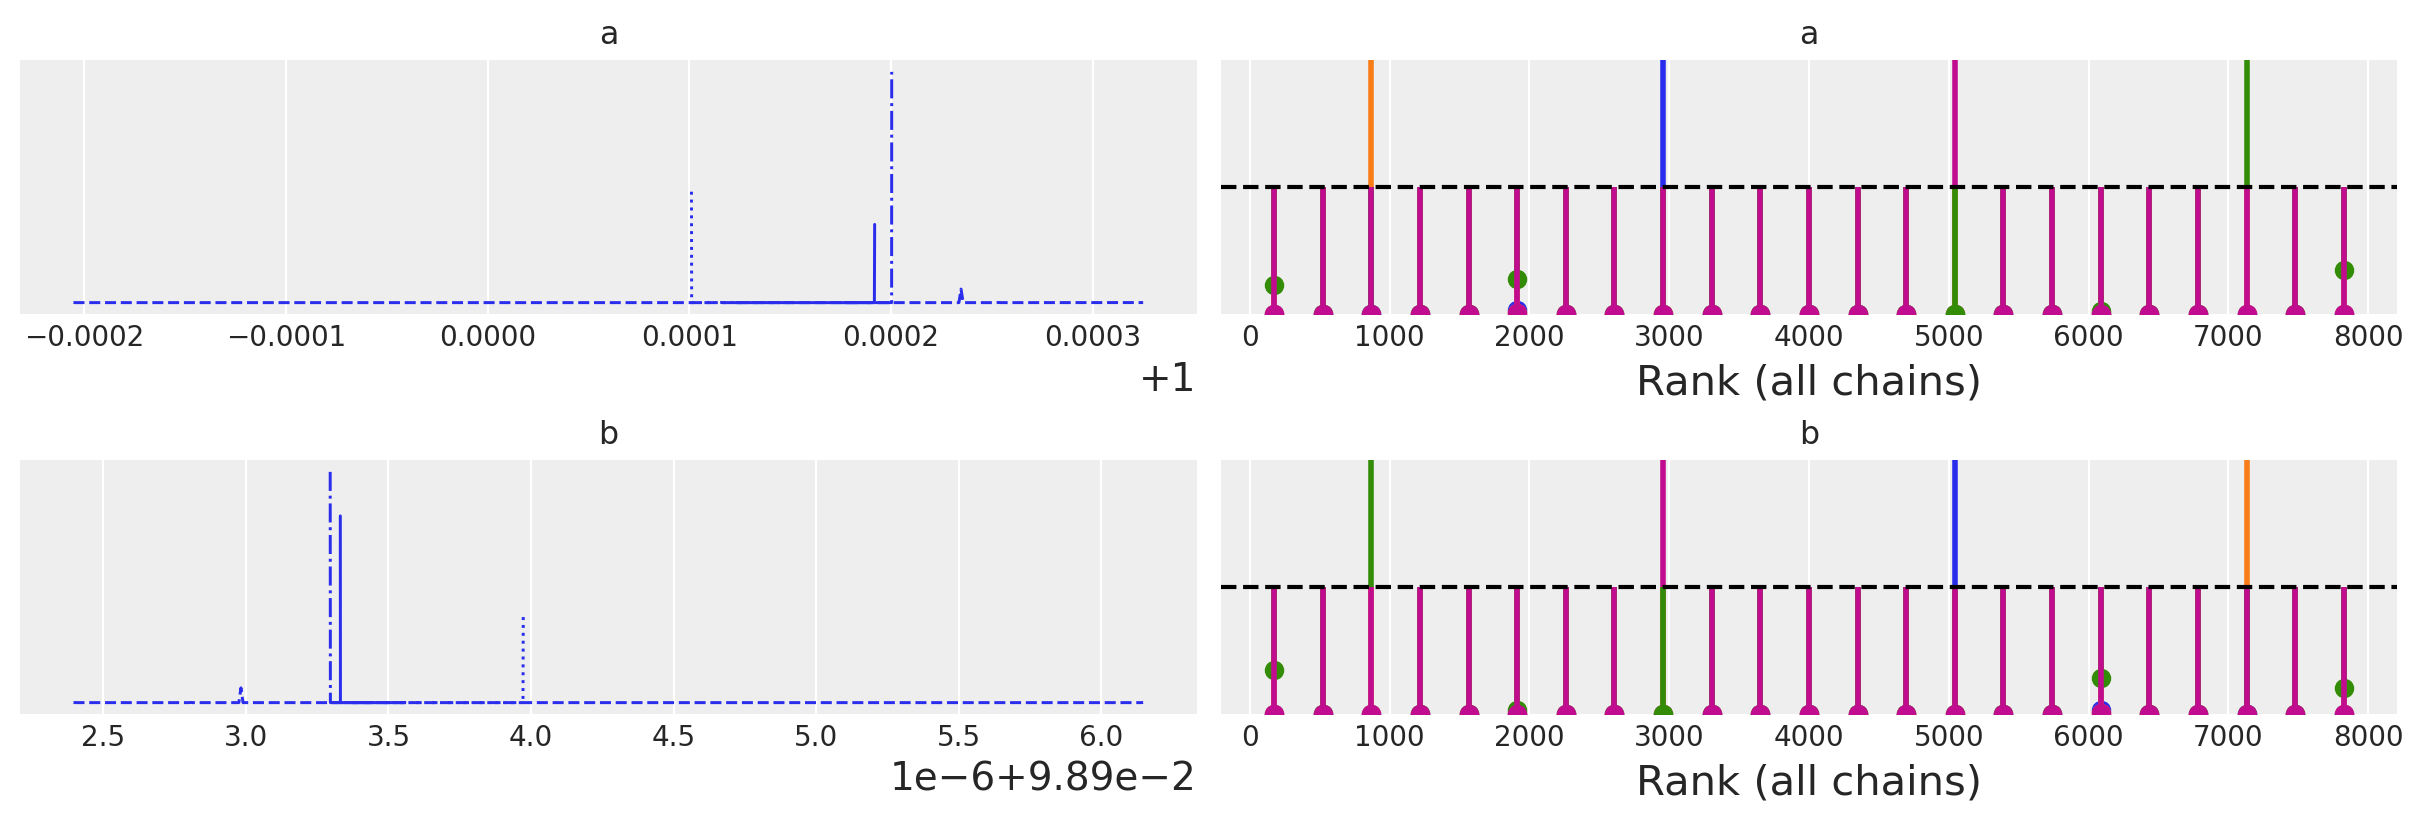

In [5]:
az.plot_trace(idata_lv, kind="rank_vlines");

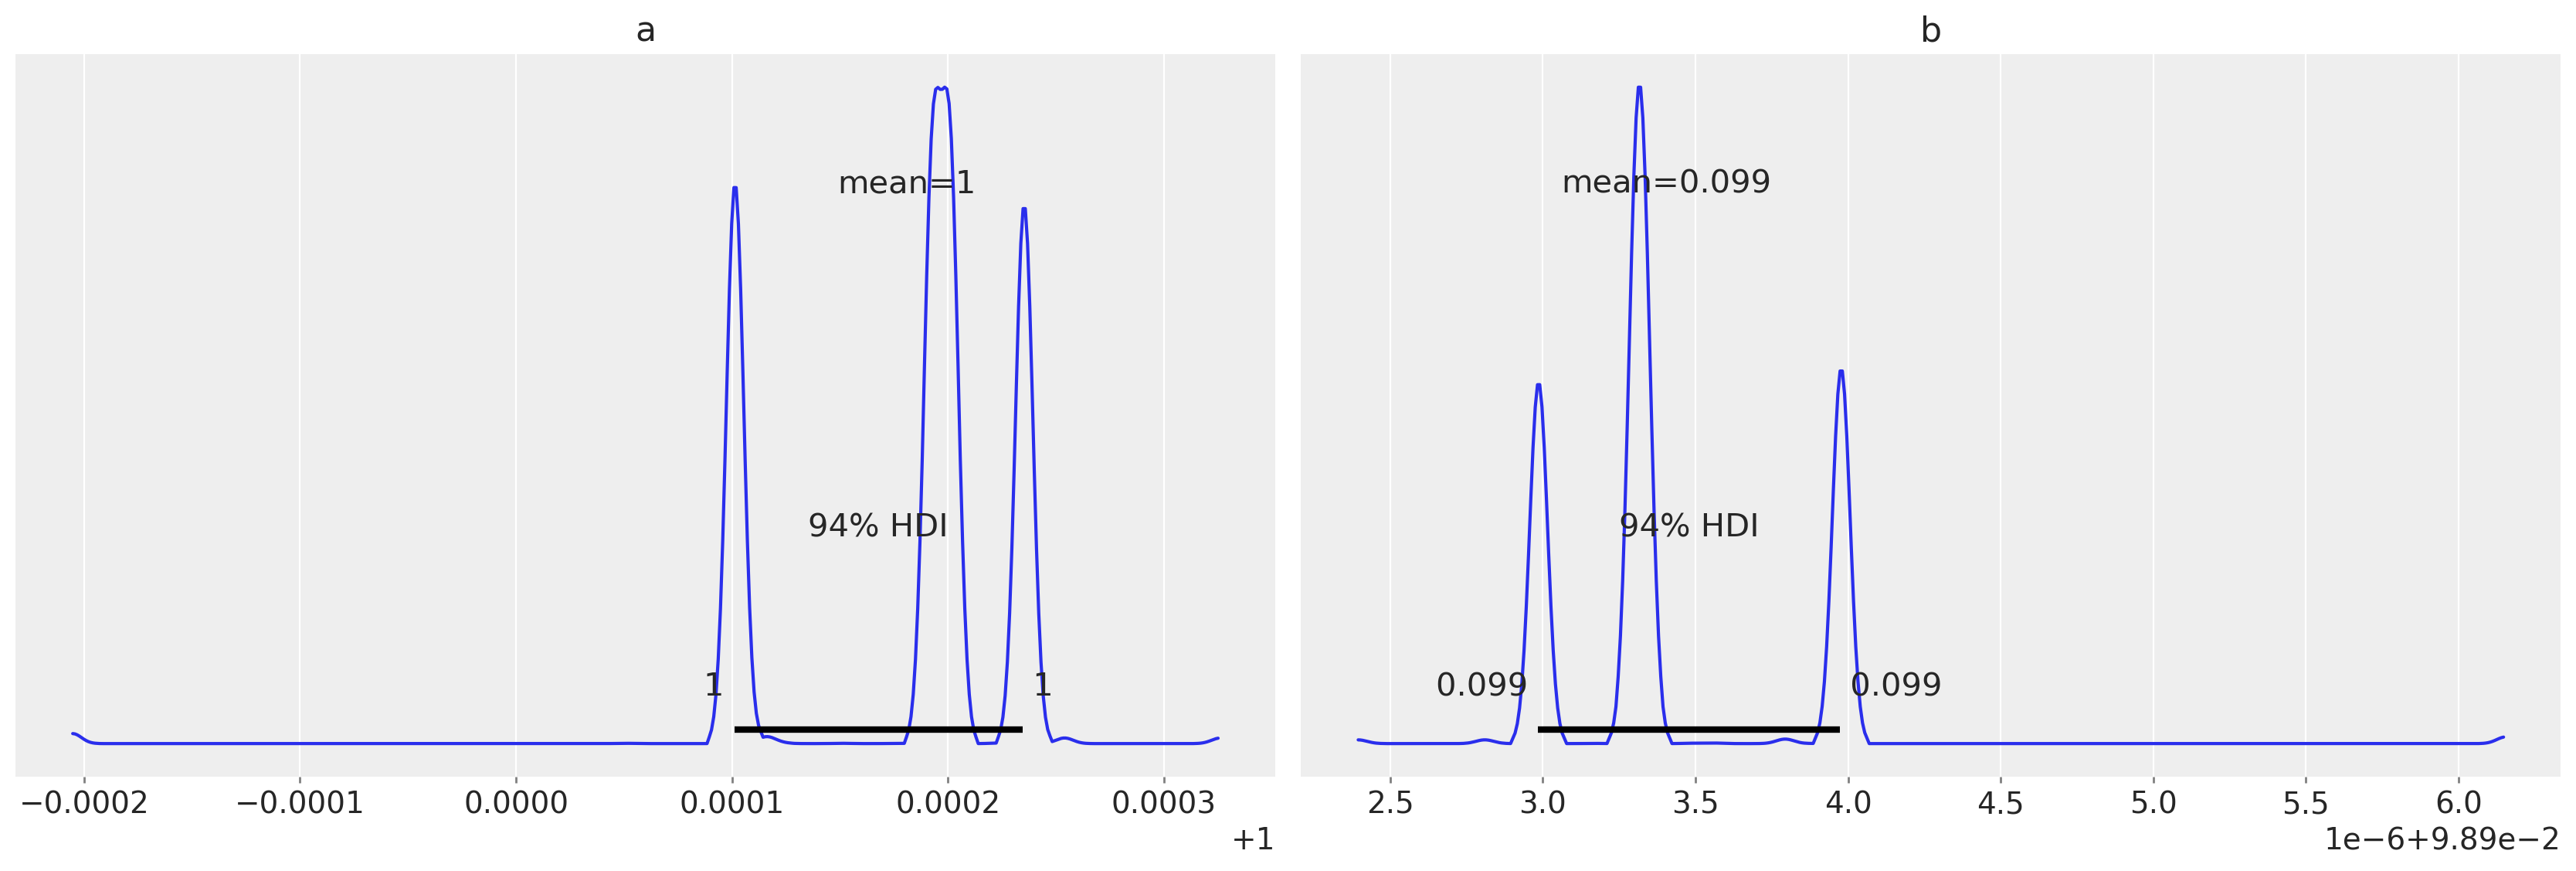

In [6]:
az.plot_posterior(idata_lv);

In [7]:
print(az.summary(idata_lv))
posterior = idata_lv.posterior.stack(samples=("draw", "chain"))
print(posterior["y0_1"].mean(), posterior["y0_2"].mean())


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.000,0.0,1.000,1.000,0.0,0.0,4.0,4.0,5.52
b,0.099,0.0,0.099,0.099,0.0,0.0,4.0,4.0,5.73


KeyError: 'y0_1'

In [ ]:
# plot results
_, ax = plt.subplots(figsize=(14, 6))
posterior = idata_lv.posterior.stack(samples=("draw", "chain"))
ax.plot(observed[:, 0], "o", label="prey", c="C0", mec="k")
ax.plot(observed[:, 1], "o", label="predator", c="C1", mec="k")

# y_posterior = ( posterior["y0_1"].mean(), posterior["y0_2"].mean())
y_posterior = (10, 5)
ax.plot(competition_model(None, y_posterior, posterior["a"].mean(), posterior["b"].mean()), linewidth=3)
# for i in np.random.randint(0, size, 10):
#     sim = competition_model(None, (posterior["y0_1"][i], posterior["y0_2"][i]), posterior["a"][i], posterior["b"][i])
#     ax.plot(sim[:, 0], alpha=0.1, c="C0")
#     ax.plot(sim[:, 1], alpha=0.1, c="C1")
ax.set_xlabel("time")
ax.set_ylabel("population")
ax.legend();